In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from karpathy_nn.micrograd.engine import Value
from karpathy_nn.micrograd.utils import draw_graph


### Gradients

In [2]:
def f(x: float | int | np.ndarray) -> float | np.ndarray:
    return 3 * x**2 - 4 * x + 5


In [3]:
f(3.0)


20.0

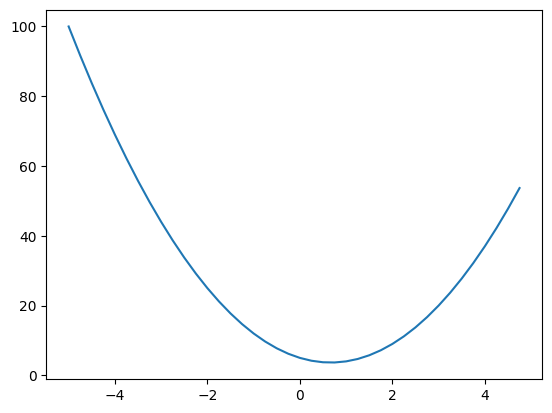

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)  # Elementwise transformations

_ = plt.plot(xs, ys)


We will not take the symbolic approach to actually calculate derivatives. (It would be infeasible anyways for today's neural networks.) Instead, we take the intuitive approach to see what the derivative of a function is measuring.

For a differentiable function $f: \mathbb{R} \rightarrow \mathbb{R}$ (i.e., the limit below exists),
$$
f'(x) = \lim_{h \rightarrow 0} \frac{f(a + h) - f(a)}{h}.
$$

- The derivative of $f$ at point $x$ tells us the relative change in the function value if we perturb $x$ by an infinitesimal amount.
- "Perturb" means either increase or decrease. For the derivative to exist, the relative change in the function value if we increase $x$ by a bit must agree with the change if we decrease $x$ by a bit.

Below we take a numerical approximation of the gradient at $x = 3$.

In [5]:
h_pos = 0.001
h_neg = -h_pos
x = 3

print("Positive change:", (f(x + h_pos) - f(x)) / h_pos)  # Rise over run
print("Negative change:", (f(x + h_neg) - f(x)) / h_neg)


Positive change: 14.00300000000243
Negative change: 13.996999999996262


$f$ is differentiable, and the true value of $f'(x)$, $x \in \mathbb{R}$ is
$$f'(x) = 6x - 4.$$
Plugging in $x = 3$, we obtain $f'(3) = 14$, which is quite close to both approximations above. As we decrease ``h_pos`` or increase ``h_neg`` towards 0, we get a better and better estimate. However, as we use floating point arithmetic (the representation of floating point numbers in computer memory is finite and binary-based), this fails after a certain point, which can be seen below.

In [6]:
h_pos = 0.0000000000000001
print("Positive change:", (f(x + h_pos) - f(x)) / h_pos)


Positive change: 0.0


At the vertex, the parabola obtains its global minimum, therefore we expect a derivative of $0$. $f$ is a parabola with the $x$ coordinate of the vertex being $2/3$, and the $y$ coordinate being the global minimum value of the function, $11/3$.

In [7]:
x = 2 / 3
h_pos = 0.000001
print("Positive change:", (f(x + h_pos) - f(x)) / h_pos)


Positive change: 2.999378523327323e-06


Let's get more complex.

We consider a function represented by output variable $d$ that is a function of three variables $a, b,$ and $c$:
$$d = ab + c.$$
We want to obtain the partial derivatives of the function with respect to $a, b,$ and $c$.

In [8]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c


Note: We explicitly write 2.0 instead of 2 throughout this notebook, because the weights will always be floats in a network, and even if we initialize a ``Value`` with an int in our ``micrograd`` framework, if we want to perform a gradient update it will be converted to a float anyway.

Is ``d2`` larger or smaller than ``d1``? This determines the sign of the derivative. We can see that $ab$ is negative, so increasing $a$ will result in a decrease of $d$. Therefore, ``d2`` is smaller than ``d1``, and the derivative must be negative.

In [9]:
print("d1", d1)
print("d2", d2)
print(
    "slope wrt. a", (d2 - d1) / h
)  # We divide by h because the derivative is a normalized change.


d1 4.0
d2 3.999699999999999
slope wrt. a -3.000000000010772


This coincides with the analytical solution:
$$\frac{dd}{da} = b = -3.$$

We can calculate the influence of the other variables on $d$ similarly:

In [10]:
# Influence of b:
# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c
print("slope wrt. b", (d2 - d1) / h)

# Influence of c:
# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c
print("slope wrt. c", (d2 - d1) / h)


slope wrt. b 2.0000000000042206
slope wrt. c 0.9999999999976694


This is correct, as
$$\frac{dd}{db} = a = 2$$
and
$$\frac{dd}{dc} = 1.$$

### Visualization

Now we can build any computational graph of scalar expressions containing only $+,$ and $*$.

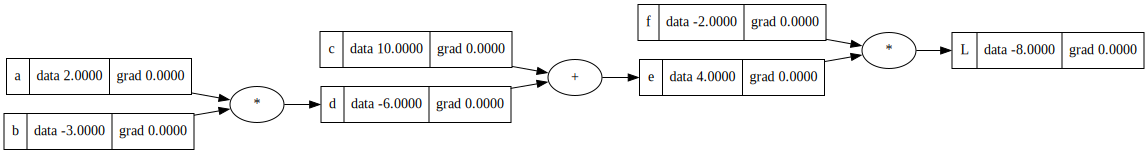

In [11]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a * b
d.label = "d"
e = d + c
e.label = "e"
f = Value(-2.0, label="f")
L = e * f
L.label = "L"

draw_graph(L)


Note: the provided gradient values are obviously incorrect, because we have not yet used backpropagation to populate them.

In [12]:
def numerical_dLde(h: float = 0.001) -> None:
    """Calculates a numerical approximation of the partial derivative of L wrt. e,
    which can be used as a gradient check.

    Args:
        h: Determines how good our approximation is. For very small h, we run into
            numerical issues.

    Returns:
        dL/da.
    """
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    d = a * b
    d.label = "d"
    e = d + c
    e.label = "e"
    f = Value(-2.0, label="f")
    L = e * f
    L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    d = a * b
    d.label = "d"
    e = d + c
    e.label = "e"
    e.data += h
    f = Value(-2.0, label="f")
    L = e * f
    L.label = "L2"
    L2 = L.data

    print("dL/de:", (L2 - L1) / h)


numerical_dLde()


dL/de: -2.000000000000668


Note: Deriving the derivative of a linear function is remarkably easy:
$$L = ef \implies \frac{dL}{de} = \lim_{h \rightarrow 0} \frac{(e+h)f - ef}{h} = f.$$
This also shows that for linear functions of a variable (like above), calculating any partial via a finite-difference approximation gives exact results. In a computer, real numbers are represented by floating point arithmetics, leading to small errors (the interpreter is not smart enough to make the simplification we just did above and will introduce errors).

For partials of $L$ wrt. variables that are not direct predecessors of it, we can use the chain rule. E.g.:
$$\frac{dL}{db} = \frac{dL}{de}\frac{de}{dd}\frac{dd}{db}.$$

Whenever we have a plus node, it only *distributes* the gradient at an "intersection" of a computational graph to both children nodes, as it keeps the gradient value unchanged (as given by the chain rule).

Whenever we have a times node, it only multiplies the incoming gradient by the other operand.

Backpropagation is just a recursive application of the chain rule, backwards through the computational graph.

### Backpropagating Through a Neuron

Biologically, neurons are very complicated biological devices. However, we can build very simple mathematical models of them, which leads us to the perceptron, and also the multi-layer perceptron (MLP).
- We have simple inputs $x_i$ to the artificial neuron. 
- The artificial neuron has **synapses** that have weights $w_i$ on them.
- The synapse interacts with the corresponding input to the neuron through its weights multiplicatively. The value that flows to the cell body through the synapse is $w_ix_i$.
- There are many synapses, as many as there are inputs. The **cell body** sums up the values that flow towards it ($\sum_i w_i x_i$) and also adds a bias term.
    - The **bias term** controls the innate trigger-happiness of the neuron. Increasing the bias can make it more trigger-happy (decreasing it does the opposite) *regardless of the input*.
- Finally, an **activation function** transforms this affine transformation of the inputs as
$$f\left(\sum_i w_i x_i + b\right)$$
which is the value that flows through the neuron's **output axon**. The activation function used to be often a squashing function (e.g. sigmoid, tanh), but nowadays the ReLU function or variations thereof are used.

Let's write out an example perceptron with a 2D input.

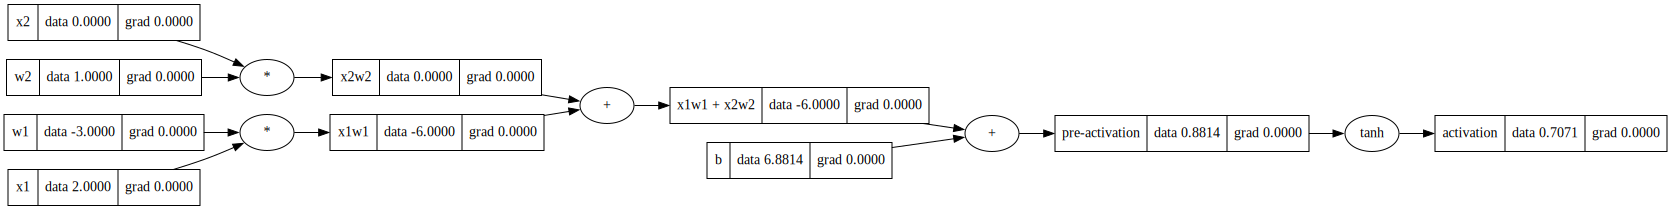

In [13]:
# Inputs: x1, x2.
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights (synaptic strengths for each input):
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of the neuron:
b = Value(6.8813735870195432, label="b")  # To have nice numbers later on.

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1plusx2w2 = x1w1 + x2w2
x1w1plusx2w2.label = "x1w1 + x2w2"
pre_activation = x1w1plusx2w2 + b
pre_activation.label = "pre-activation"
activation = pre_activation.tanh()
activation.label = "activation"

draw_graph(activation)


We are doing everything in tiny steps, such that we have pointers to all intermediate computations and our computational graph is pretty. It *is* pretty, but the ``grad`` values are incorrect, because we have not yet run backpropagation. Let's quickly do that.

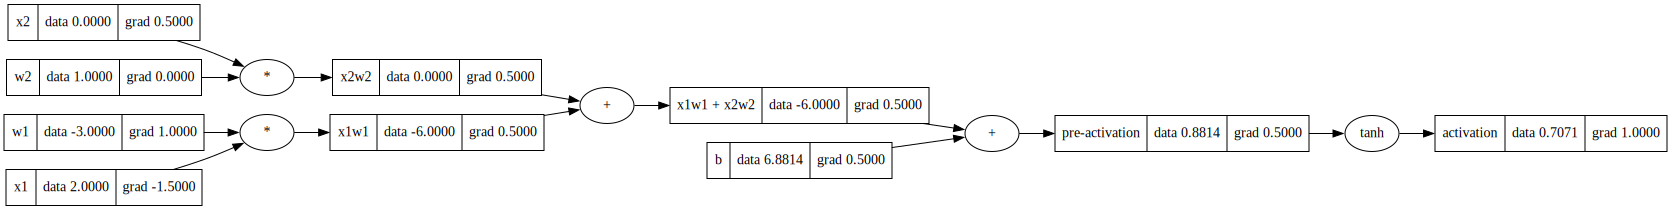

In [14]:
activation.backward()
draw_graph(activation)


Now everything seems correct. Let's now try to decrease the value of $L$. To this end, we can simply nudge each of the leaf variables in the direction of their gradient manually.

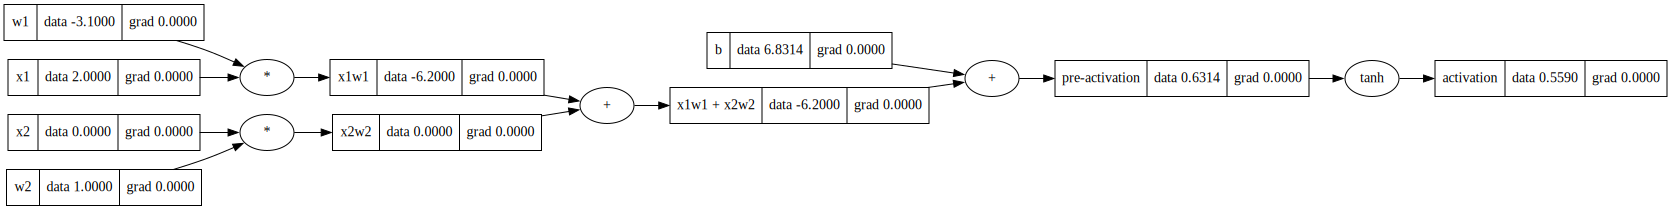

In [15]:
learning_rate = 0.1
w1.data = w1.data - learning_rate * w1.grad
w2.data = w2.data - learning_rate * w2.grad
b.data = b.data - learning_rate * b.grad

# Run forward propagation again.
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1plusx2w2 = x1w1 + x2w2
x1w1plusx2w2.label = "x1w1 + x2w2"
pre_activation = x1w1plusx2w2 + b
pre_activation.label = "pre-activation"
activation = pre_activation.tanh()
activation.label = "activation"

# We do not need the gradients anymore.
w1.grad = 0
w2.grad = 0
b.grad = 0
x1.grad = 0
x2.grad = 0

draw_graph(activation)


The loss value decreased as expected. This is one step of the optimization of the parameters. As this linearization only works for small steps, we always have to re-linearize at each step.

As we correctly accumulate the gradients in the ``.backward()`` code, we also obtain the correct results in the trickier cases below.

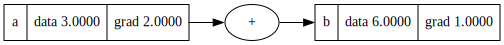

In [16]:
a = Value(3.0, label="a")
b = a + a
b.label = "b"
b.backward()
draw_graph(b)


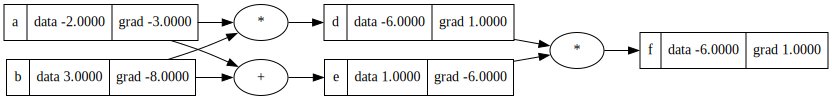

In [17]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b
d.label = "d"
e = a + b  # Second use of a and b.
e.label = "e"
f = d * e
f.label = "f"
f.backward()
draw_graph(f)


Let's break up the ``tanh`` into its actual definition in our neuron to see that we get exactly the same gradients by doing so.

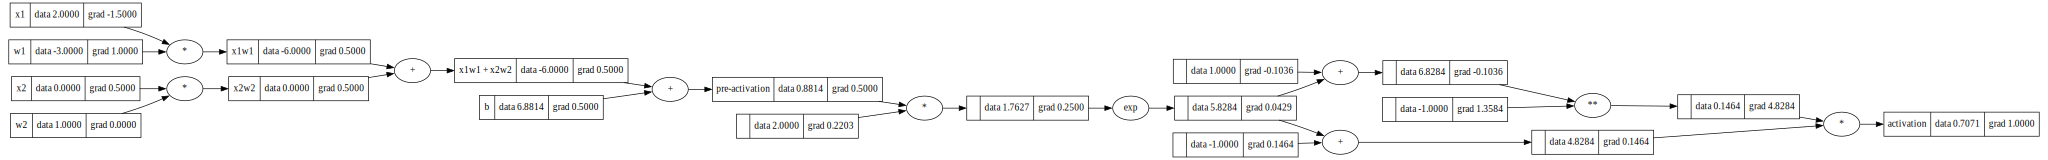

In [18]:
# Inputs: x1, x2.
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights (synaptic strengths for each input):
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of the neuron:
b = Value(6.8813735870195432, label="b")  # To have nice numbers later on.

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1plusx2w2 = x1w1 + x2w2
x1w1plusx2w2.label = "x1w1 + x2w2"
pre_activation = x1w1plusx2w2 + b
pre_activation.label = "pre-activation"
intermediate = (2 * pre_activation).exp()
activation = (intermediate - 1) / (intermediate + 1)
activation.label = "activation"
activation.backward()

draw_graph(activation)


We get exactly the same activations and gradients as before, but now we also have many more intermediate gradients. This means that the forward and backward implementations are coherent across mathematical equivalences.

Now let's see how we could implement a neuron like this in PyTorch. As the Python float is double precision, if we want to get an equivalent method in PyTorch, we will have to use double precision as well.

In [19]:
x1 = torch.tensor(2.0, dtype=torch.double, requires_grad=True)
x2 = torch.tensor(0.0, dtype=torch.double, requires_grad=True)
w1 = torch.tensor(-3.0, dtype=torch.double, requires_grad=True)
w2 = torch.tensor(1.0, dtype=torch.double, requires_grad=True)
b = torch.tensor(6.8813735870195432, dtype=torch.double, requires_grad=True)
pre_activation = x1 * w1 + x2 * w2 + b
activation = pre_activation.tanh()

print("activation:", activation.item())

activation.backward()

print("x2.grad:", x2.grad.item())
print("w2.grad:", w2.grad.item())
print("x1.grad:", x1.grad.item())
print("w1.grad:", w1.grad.item())


activation: 0.7071067811865476
x2.grad: 0.4999999999999999
w2.grad: 0.0
x1.grad: -1.4999999999999996
w1.grad: 0.9999999999999998


We get exactly the same results, up to numerical precision. Of course, PyTorch is much more advanced than ``micrograd`` and works on tensors of arbitrary shape. PyTorch is significantly more efficient by design: by structuring scalars into tensors, we can do many operations in parallel (SIMD). Still, in essence, we can do everything with the micrograd design.